In [ ]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#loading data using datasets API
training_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
testing_set = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

#preparing validation set from training set
training_set, validation_set = torch.utils.data.random_split(training_set, [int(0.9 * len(training_set)), int(0.1 * len(training_set))])


training_dataloader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False)
testing_dataloader = torch.utils.data.DataLoader(testing_set, batch_size=32, shuffle=False)

print("Training dataset size: ", len(training_set))
print("Validation dataset size: ", len(validation_set))
print("Testing dataset size: ", len(testing_set))

Training dataset size:  54000
Validation dataset size:  6000
Testing dataset size:  10000


In [ ]:
#constructing the CNN class

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

#defining CNN object, loss function, and optimizer to train the network
network = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)


Epoch: 1/100, training Loss: 0.28825735, validation Loss: 0.06792513, validation Accuracy: 0.98116667
Saving the network state dictionary for Epoch: 1 with validation loss: 0.06792513

Epoch: 2/100, training Loss: 0.10077561, validation Loss: 0.05144528, validation Accuracy: 0.98666667
Saving the network state dictionary for Epoch: 2 with validation loss: 0.05144528

Epoch: 3/100, training Loss: 0.07726996, validation Loss: 0.04332452, validation Accuracy: 0.98766667
Saving the network state dictionary for Epoch: 3 with validation loss: 0.04332452

Epoch: 4/100, training Loss: 0.06245767, validation Loss: 0.04536809, validation Accuracy: 0.98733333

Epoch: 5/100, training Loss: 0.05254897, validation Loss: 0.03429194, validation Accuracy: 0.98900000
Saving the network state dictionary for Epoch: 5 with validation loss: 0.03429194

Epoch: 6/100, training Loss: 0.04679373, validation Loss: 0.04118432, validation Accuracy: 0.98933333

Epoch: 7/100, training Loss: 0.03994996, validation L

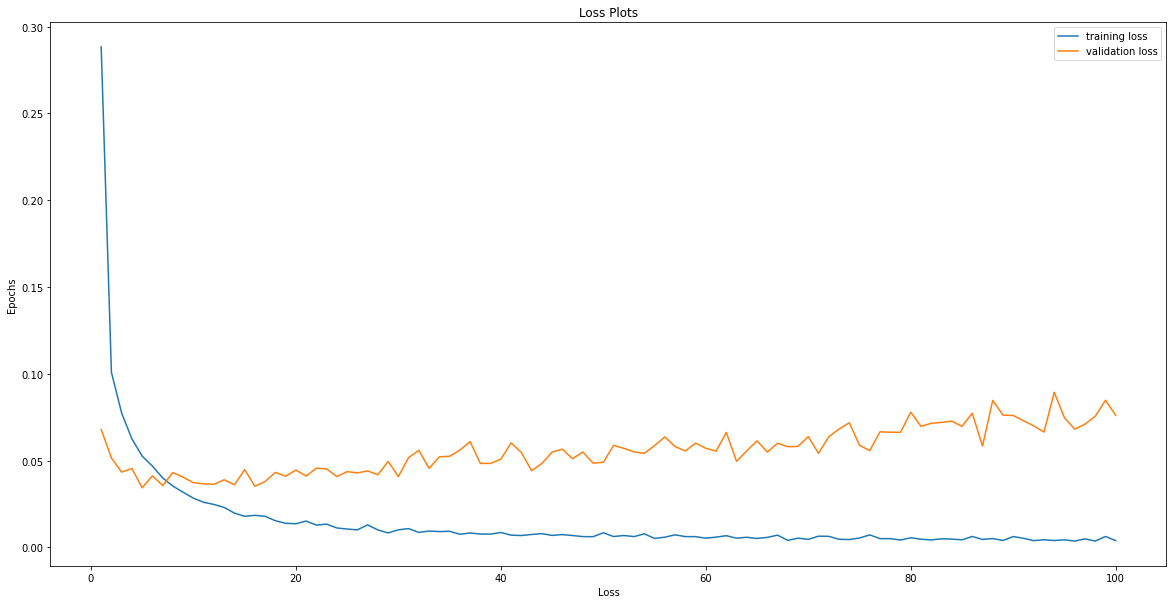

In [ ]:
#training and validating oue network

if (torch.cuda.is_available()):
    network.cuda()

no_epochs = 100
training_loss = list()
validation_loss = list()
best_validation_loss = 1
for epoch in range(no_epochs):
    total_training_loss = 0
    total_validation_loss = 0

    network.train()
    # training
    for itr, (image, label) in enumerate(training_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = network(image)

        loss = criterion(pred, label)
        total_training_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_training_loss = total_training_loss / (itr + 1)
    training_loss.append(total_training_loss)

    # validation
    network.eval()
    total = 0
    for itr, (image, label) in enumerate(validation_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = network(image)

        loss = criterion(pred, label)
        total_validation_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(validation_set)

    total_validation_loss = total_validation_loss / (itr + 1)
    validation_loss.append(total_validation_loss)

    print('\nEpoch: {}/{}, training Loss: {:.8f}, validation Loss: {:.8f}, validation Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_training_loss, total_validation_loss, accuracy))

    if total_validation_loss < best_validation_loss:
        best_validation_loss = total_validation_loss
        print("Saving the network state dictionary for Epoch: {} with validation loss: {:.8f}".format(epoch + 1, total_validation_loss))
        torch.save(network.state_dict(), "network.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), training_loss, label="training loss")
plt.plot(np.arange(1, no_epochs+1), validation_loss, label="validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# test network
network.load_state_dict(torch.load("network.dth"))
network.eval()

results = list()
total = 0
for itr, (image, label) in enumerate(testing_dataloader):
    pred = network(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / (itr + 1)
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 31.60063898
